<div style="text-align: center;">
    <span style="font-size:30px; font-weight: bold;">CNN for feature extraction and RBF Neural Network</span>
</div>

1. Load Data and start Preprocessing

In [7]:
import tensorflow as tf
import numpy as np
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# Load Data and start Preprocessing
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.cifar10.load_data()
class_names = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

# Scale pixel values to the range [0, 1]
x_train = x_train / 255.0
x_test = x_test / 255.0

# Transform Labels into one Hot Encoding
one_hot_enc=OneHotEncoder(sparse_output=False)
y_train=one_hot_enc.fit_transform(y_train.reshape(-1,1))
y_test=one_hot_enc.transform(y_test.reshape(-1,1))

2. CNN - Feature Extraction

In [8]:
# Use the CNN *of the first Assignment* without the final classification layer - Just for the Feature Extraction
base_CNN = tf.keras.Sequential([
    tf.keras.layers.Conv2D(32, (3, 3), padding='same', activation='relu', input_shape=(32, 32, 3)),
    tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),
    tf.keras.layers.Dropout(0.3),
    tf.keras.layers.Conv2D(64, (3, 3), padding='same', activation='relu'),
    tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),
    tf.keras.layers.Dropout(0.3),
    tf.keras.layers.Conv2D(128, (3, 3), padding='same', activation='relu'),
    tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),
    tf.keras.layers.Dropout(0.3),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(1024, activation='relu'),
    tf.keras.layers.Dropout(0.5),
])

CNN = tf.keras.Sequential([base_CNN, tf.keras.layers.Dense(10, activation='softmax')])

# Compile and train the CNN
CNN.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
CNN.fit(x_train, y_train, epochs=50, batch_size=64, validation_data=(x_test, y_test))

# Use CNN's base as a feature extractor
feature_extractor = tf.keras.Model(inputs=base_CNN.input, outputs=base_CNN.output)

# Extract features
train_features = feature_extractor.predict(x_train)
test_features = feature_extractor.predict(x_test)

C:\Users\nirva\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/50
782/782 ━━━━━━━━━━━━━━━━━━━━ 20s 24ms/step - accuracy: 0.3134 - loss: 1.8353 - val_accuracy: 0.5464 - val_loss: 1.2714
Epoch 2/50
782/782 ━━━━━━━━━━━━━━━━━━━━ 18s 23ms/step - accuracy: 0.5341 - loss: 1.2952 - val_accuracy: 0.6381 - val_loss: 1.0408
Epoch 3/50
782/782 ━━━━━━━━━━━━━━━━━━━━ 18s 23ms/step - accuracy: 0.6028 - loss: 1.1148 - val_accuracy: 0.6753 - val_loss: 0.9372
Epoch 4/50
782/782 ━━━━━━━━━━━━━━━━━━━━ 18s 24ms/step - accuracy: 0.6352 - loss: 1.0246 - val_accuracy: 0.7013 - val_loss: 0.8537
Epoch 5/50
782/782 ━━━━━━━━━━━━━━━━━━━━ 18s 23ms/step - accuracy: 0.6706 - loss: 0.9398 - val_accuracy: 0.7047 - val_loss: 0.8449
Epoch 6/50
782/782 ━━━━━━━━━━━━━━━━━━━━ 20s 25ms/step - accuracy: 0.6860 - loss: 0.8962 - val_accuracy: 0.7102 - val_loss: 0.8217
Epoch 7/50
782/782 ━━━━━━━━━━━━━━━━━━━━ 24s 31ms/step - accuracy: 0.7008 - loss: 0.8499 - val_accuracy: 0.7331 - val_loss: 0.7721
Epoch 8/50
782/782 ━━━━━━━━━━━━━━━━━━━━ 23s 30ms/step - accuracy: 0.7121 - loss: 0.8215 - 

3. RBFNN Implementation for the Classification part

In [9]:
# Train RBFNN on extracted features
n_hidden = 5500
kmeans = KMeans(n_clusters = n_hidden, random_state=42)
kmeans.fit(train_features)
centers = kmeans.cluster_centers_

sigma= np.mean([np.linalg.norm(center-centers, axis =1).mean() for center in centers])  # Approximation for sigma

# Compute hidden layer outputs
def hiddenlayer_output(X, centers,sigma):
    n_samples = X.shape[0]
    n_hidden = centers.shape[0]
    output = np.zeros((n_samples,n_hidden))
    for i in range(n_samples):
        output[i, :] = np.exp(-np.linalg.norm(X[i]-centers, axis=1)**2 / (2 * sigma**2))
    return output

hidden_output_train = hiddenlayer_output(train_features, centers,sigma)
hidden_output_test = hiddenlayer_output(test_features, centers, sigma)

# Train output layer using pseudo-inverse
output_weights = np.linalg.pinv(hidden_output_train).dot(y_train)

# Make predictions
y_pred_train = np.argmax(hidden_output_train.dot(output_weights), axis=1)
y_pred_test = np.argmax(hidden_output_test.dot(output_weights), axis=1)


4. Metrics

Training Accuracy: 96.31
Test Accuracy: 80.18


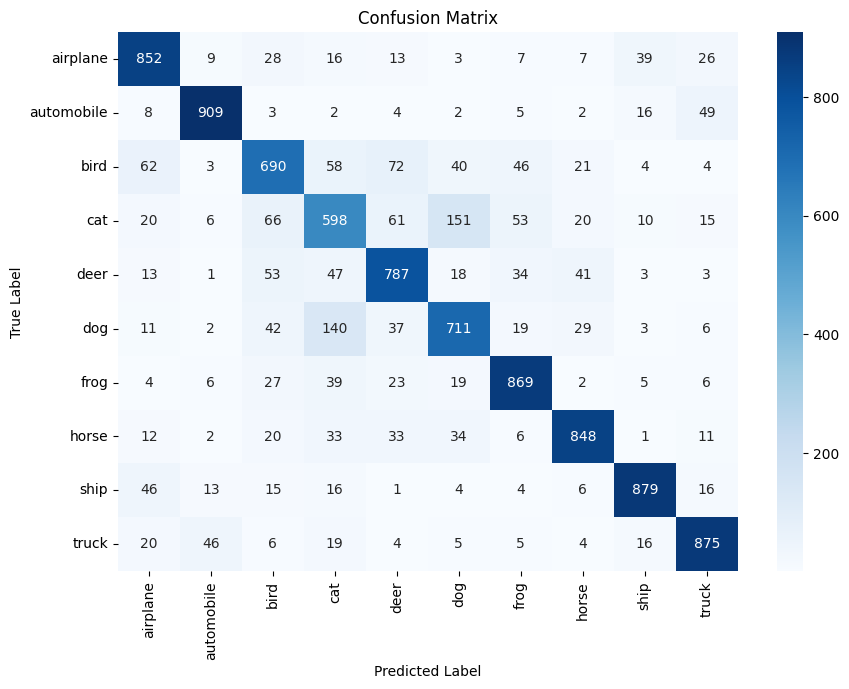

In [11]:
# Evaluate RBFNN
# Calculate and print training accuracy
train_accuracy = accuracy_score(y_train.argmax(axis=1), y_pred_train)
print(f"Training Accuracy: {train_accuracy * 100:.2f}")

# Calculate and print test accuracy
test_accuracy = accuracy_score(y_test.argmax(axis=1), y_pred_test)
print(f"Test Accuracy: {test_accuracy * 100:.2f}")

# Confusion Matrix
def plot_confusion_matrix(y_true, y_pred, class_names):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(10, 7))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=class_names, yticklabels=class_names)
    plt.title("Confusion Matrix")
    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")
    plt.show()


plot_confusion_matrix(y_test.argmax(axis=1), y_pred_test, class_names)


5. Examples of Correct and Incorrect Classification

Correct Classification Examples:


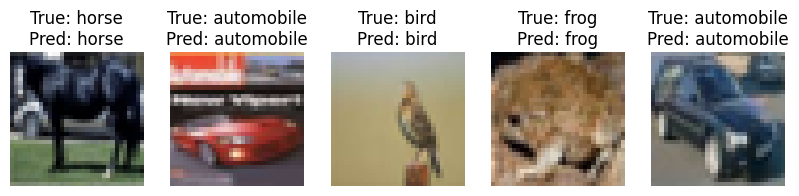

Incorrect Classification Examples:


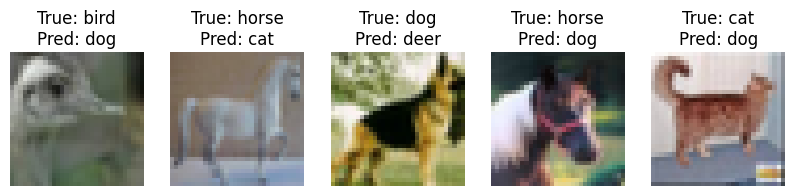

In [13]:
def plot_classification_examples(x_test, y_test, y_pred, class_names, correct=True):
    
    if correct:
        indices = np.where(y_pred == y_test)[0]
    else:
        indices = np.where(y_pred != y_test)[0]
    idx = np.random.choice(indices, 5, replace=False)
        
    plt.figure(figsize=(10, 5))
    for i, idx in enumerate(idx):
        plt.subplot(1, 5, i+1)
        plt.imshow(x_test[idx].reshape(32, 32, 3))  # Reshape the image back to 32x32x3
        plt.title(f"True: {class_names[y_test[idx]]}\nPred: {class_names[y_pred[idx]]}")
        plt.axis('off')
    plt.show()

print("Correct Classification Examples:")
plot_classification_examples(x_test, y_test.argmax(axis=1), y_pred_test, class_names, correct=True)

print("Incorrect Classification Examples:")
plot_classification_examples(x_test, y_test.argmax(axis=1), y_pred_test, class_names, correct=False)
